# <center> Mouvement d'un corps dans le système solaire

### Etienne PROFIT
### Maxime MUNIER

### Introduction : 
<br>
Le but de ce projet est de prédire la trajectoire d'un objet dans le système solaire. Tout d'abord, nous allons nous intéresser à l'orbite terrestre que nous déterminerons grâce aux paramètres Kepleriens dans le cadre d'un problème à 2 corps. Ensuite nous appliquerons ce procédé aux 8 planètes du système solaire et nous tracerons leurs orbites et détermineront leurs position en fonction du temps. Enfin, nous appliquerons le principe fondamental de la dynamique sur un objet quelconque situé n'importe où dans le système solaire, et par intégration, nous en déduirons ses positions successives en fonction du temps

In [157]:
# Quelques imports nécéssaires au bon déroulement du projet

#Si vous utilisez le programme sous JupyterLab au lieu de Jupyter Notebook, les étapes suivantes sont à réaliser afin de permettre l'interactivité des graph
#Dans la console, tapez les lignes suivantes (sans les #)
#conda install -y nodejs
#pip install ipympl
#jupyter labextension install @jupyter-widgets/jupyterlab-manager
#jupyter labextension install jupyter-matplotlib
#jupyter nbextension enable --py widgetsnbextension
#Redémarrez JupyterLab

import numpy as np
import matplotlib.pyplot as plt
from math import *
import pandas as pd
from ipywidgets import *
from matplotlib.widgets import Slider
from matplotlib.widgets import TextBox
from mpl_toolkits import mplot3d

In [2]:
# Constantes du problème
G=6.6743e-11 #m**3/kg/s²

### Partie I : Orbite d'un corps autour du soleil

Ici, on va tenter de formaliser l'orbite d'un corps autour d'une planète en passant par les expressions des différentes anomalies.

D'abord, l'anomalie moyenne M peut être calculée facilement en fonction du temps et du moyen mouvement d'une planète. Ces moyens mouvements ont été trouvé sur le site de la nasa (voir Bibliographie en fin de document).

$$ M= n\times(t-t_{0}) $$
 
   
avec :
* $M$ : anomalie moyenne en radian, 
* $n$ : moyen mouvement en radian/jour, 
* $t$ : temps choisi et 
* $t_{0}$: passage de la planète au périapside
    

On va effectuer nos calculs pour la planète Terre afin d'éprouver leur efficacité.

In [158]:
# Fonction calculant l'anomalie moyenne en fonction du temps, du moyen mouvement d'un corps,
#et de l'origine des temps, passage de la planète au périapside
def M(t,m,t0):
    return m*(t-t0)

On peut utiliser cette anomalie moyenne pour déterminer l'anomalie excentrique à un instant t grâce au calcul suivant : 

$$
E=M+e\times\sin(E)
$$
avec :
* $M$ : anomalie moyenne en radian (calculée ci-dessus)
* $e$ : excentricité (donnée trouvée sur les éphémérides du Jet Propulsion Laboratory)
* $E$ : anomalie excentrique en radian


In [159]:
# Fonction calculant l'anomalie excentrique en fonction de l'anomalie moyenne et de l'excentricité
def E(M,e):
    E = M
    for i in range(0,5):
        E = M + e * np.sin(E)
    return E

De cette anomalie excentrique peut être déduite l'anomalie vrai à l'instant t tel que : 
$$
\tan(\frac{V}{2})=\sqrt{\frac{1+e}{1-2}}\tan(\frac{E}{2})
$$
<br>
et donc : 
<br>
    
$$
V=2\times\arctan(\sqrt{\frac{1+e}{1-2}}tan(\frac{E}{2}))
$$
avec :
* $V$ : anomalie vraie en radian
* $e$ : excentricité (donnée trouvée sur les éphémérides du Jet Propulsion Laboratory)
* $E$ : anomalie excentrique en radian



In [164]:
def V(E,e):
    return 2*np.arctan((np.sqrt(1+e)/np.sqrt(1-e))*np.tan(E/2))

Finalement, on utilise cette anomalie vraie pour déterminer la distance du corps à son astre, en fonction du demi grand-axe a.
$$
R=\frac{a(1-e)^2}{1+e\cos(V)}
$$

avec :
* $R$ : distance du corps à son astre
* $V$ : anomalie vraie en radian
* $e$ : excentricité (donnée trouvée sur les éphémérides du Jet Propulsion Laboratory)
* $a$ : demi-grand-axe (donnée trouvée sur les éphémérides du Jet Propulstion Laboratory)

In [165]:
def R(anom, a, e):
    return ((a*(1-e**2))/(1+e*np.cos(anom)))

Eprouvons maintenant ces méthodes sur l'orbite terrestre. Cette orbite dure 365 jours environ. Cela donne 31536000 secondes.

In [166]:
year= 31536000#s
nbdays=365 #j
time=np.linspace(0,365,366)
ex_terre=0.01671022
a=149.6*10**9 #m
mm=0.01720 #rad/s
t0=0 #s


#Calcul pour la terre
M_terre=M(time,mm,t0)
E_terre=E(M_terre,ex_terre)
V_terre=V(E_terre,ex_terre)
R_terre=R(V_terre,a,ex_terre)

In [163]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')
ax.plot(V_terre,R_terre)
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

On note que l'on obtient un résultat intéressant, une orbite circulaire cohérente à ce que nous attendions.On peut créer une fonction qui réalise le travail précédent automatiquement et que l'on utilisera dans la suite du projet.


In [167]:
# Cette fonction calcule la position au jour j de la planète étudiée en fonction 
# de son excentricité e, de son moyen mouvement mm et de son demi grand axe a, et
# de sa position initiale t0, puis renvoie ses coordonnées cartesiennes.
def pos_planete(j,e,a,mm,t0):
    M_tmp = M(j,mm,t0)
    E_tmp = E(M_tmp,e)
    V_tmp = V(E_tmp,e)
    R_tmp = R(V_tmp,a,e)
    x = R_tmp * np.cos(V_tmp)
    y = R_tmp * np.sin(V_tmp)
    return [x,y,0]

### Partie 2 : Orbite des planètes du système solaire autour du soleil
<br>
Appliquons maintenant ce procédé aux autres planètes du système solaire. 

##### 1- Ajout des données récoltées

Afin de calculer l'anomalie vraie et la distance du corps à son astre pour toutes les autres planètes, on créé un fichier dataplanets.csv comprenant les données récupérées sur les sites du JET PROPULSION LABORATORY et de la NASA. 

In [168]:
#Ajout des données pour les orbites des différentes planètes 
data=pd.read_csv('dataplanets.csv',delimiter=',' )


#Organisation des données par listes
nom = data.PLANETE.tolist()
demi_gd_axe=data.DEMIGRANDAXE.tolist()
excentricite=data.EXCENTRICITE.tolist()
temps_sec=data.PERIODESEC.tolist()
temps_jours=data.PERIODEJOUR.tolist()
ANGLES=data.ANGLES.tolist()
Tzero=data.T0.tolist()
masses=data.MASSE.tolist()


##### 2- Estimation des erreurs

Un modèle étant une représentation simplifiée de la réalité, nous avons du faire des choix sur les paramètres à conserver, et ceux à écarter. Ces hypothèses simplificatrices seront annoncées et leur impact mesuré tout au long du projet.
<br>


En premier lieu,nous avons décidé, de considérer les orbites des planètes comme étant toutes sur le plan de l'écliptique et ayant des orbites centrées sur le soleil. Nous allons cependant calculer les différences de position au demi-grand-axe (a) en prenant en compte l'angle de l'orbite de chaque planète (nommé "i" et donnée par rapport au plan de l'écliptique) afin d'estimer l'erreur sur la position des planètes. Pour cela, nous allons appliquer des règles de trigonométrie dans un triangle selon le schéma suivant : 



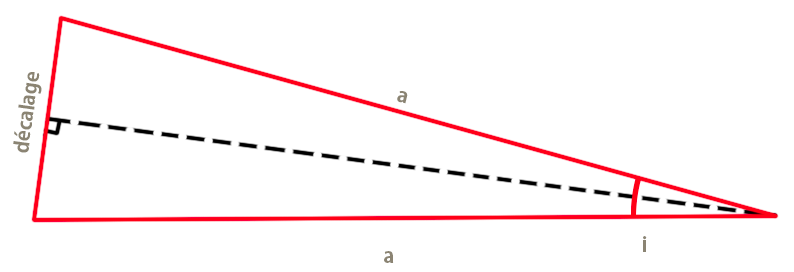

Le demi-grand-axe étant le même quelque soit l'inclinaison de l'orbite. On applique donc la formule suivante : 
$$
sin(\frac{i}{2})*a=\frac{1}{2}décalage
$$
et donc : 
$$
décalage=2*sin(\frac{i}{2})*a
$$

In [169]:
#Création de notre fonction pour le calcul du décalage
def decal (a,i):
    return abs(2 * np.sin(np.deg2rad(i/2)) * a)


In [170]:
#Calcul du décalage par planètes 
decal_planetes=[]

for i in range(len(nom)) : 
    decal_planetes.append(decal(demi_gd_axe[i],ANGLES[i]))
    
for i in range(len(nom)):
    print("On obtient pour", nom[i],", un décalage de :",np.round(decal_planetes[i],2), "m")

On obtient pour MERCURE , un décalage de : 7070516776.59 m
On obtient pour VENUS , un décalage de : 6420278433.62 m
On obtient pour TERRE , un décalage de : 0.0 m
On obtient pour MARS , un décalage de : 7558744103.24 m
On obtient pour JUPITER , un décalage de : 17661955727.56 m
On obtient pour SATURNE , un décalage de : 62536741584.84 m
On obtient pour URANUS , un décalage de : 40156151582.4 m
On obtient pour NEPTUNE , un décalage de : 142285067711.54 m


Rapportons maintenant ce décalage au demi-grand-axe afin d'obtenir un ordre d'idée de l'influence de cette simplification sur nos calculs futurs : 


In [13]:
#Calculons le pourcentage de décalage par rapport au demi-grand-axe : 
pourcentages_decal=[]
for i in range(len(nom)):
    pourcentages_decal.append(decal_planetes[i]*100/(demi_gd_axe[i]))

for i in range(len(nom)):
    print("Le décalage représente, pour", nom[i],":",round(pourcentages_decal[i],2), "% de son demi grand axe")

Le décalage représente, pour MERCURE : 12.21 % de son demi grand axe
Le décalage représente, pour VENUS : 5.93 % de son demi grand axe
Le décalage représente, pour TERRE : 0.0 % de son demi grand axe
Le décalage représente, pour MARS : 3.32 % de son demi grand axe
Le décalage représente, pour JUPITER : 2.27 % de son demi grand axe
Le décalage représente, pour SATURNE : 4.36 % de son demi grand axe
Le décalage représente, pour URANUS : 1.4 % de son demi grand axe
Le décalage représente, pour NEPTUNE : 3.14 % de son demi grand axe


Un modèle est par nature, une représentation simplifiée de la réalité, afin d'estimer l'erreur de notre modèle nous comparerons en fin de document, les données des planètes modélisées à celles trouvées dans des ephemerides.

##### 3- Représentation des orbites

Représentons donc maintenant les orbites des différentes planètes. Dans la suite du projet, on fera référence aux planètes intérieures pour MERCURE,VENUS,TERRE,MARS, et aux planètes extérieures pour JUPITER,SATURNE,URANUS,NEPTUNE

In [171]:
#Calcul du moyen mouvement en rad/s pour les différentes planètes
moy_mouv_s=[]
for i in range(len(nom)):
    moy_mouv_s.append((2*np.pi)/temps_sec[i])

#Création des listes pour les valeurs calculées
M_list=[]
E_list=[]
V_list=[]
R_list=[]
T_list=[]


#Remplissage des listes pour le calcul des orbites
for i in range(len(nom)):
    T_list.append(np.linspace(0,int(temps_sec[i]),int(temps_jours[i])))
    M_list.append(M(T_list[i],moy_mouv_s[i],Tzero[i]))
    E_list.append(E(M_list[i],excentricite[i]))
    V_list.append(V(E_list[i],excentricite[i]))
    R_list.append(R(V_list[i],demi_gd_axe[i],excentricite[i]))
    


In [172]:
#Représentation graphique en projection polaire plane
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')

ax.plot(0,0,'ro',c='yellow',label='SOLEIL')

ax.plot(V_list[0],R_list[0], c='grey', label='MERCURE')
ax.plot(V_list[1],R_list[1], c='brown', label='VENUS')
ax.plot(V_list[2],R_list[2], c='dodgerblue', label='TERRE')
ax.plot(V_list[3],R_list[3], c='red', label='MARS')


plt.title("Orbites des planètes internes")


legend = plt.legend(loc = 'best')


plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

On passe ensuite en coordonnées cartésiennes pour pouvoir calculer la trajectoire de notre objet et pour plot en 3d afin d'avoir une représentation en perspective.  

In [173]:
#Passage en coordonnées cartésiennes pour plot les orbites en 3d

def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
   
    return(x,y)

#Listes de position pour créer les orbites
MERCURE=pol2cart(R_list[0],V_list[0])
VENUS=pol2cart(R_list[1],V_list[1])
TERRE=pol2cart(R_list[2],V_list[2])
MARS=pol2cart(R_list[3],V_list[3])
JUPITER=pol2cart(R_list[4],V_list[4])
SATURNE=pol2cart(R_list[5],V_list[5])
URANUS=pol2cart(R_list[6],V_list[6])
NEPTUNE=pol2cart(R_list[7],V_list[7])


Nous allons ensuite créer des fonctions permettant de représenter les orbites des planètes ainsi que la position de celles-ci sur leurs orbites : 

In [174]:
#Calcul du moyen mouvement en rad/j pour les différentes planètes
moy_mouv=[]
for i in range(len(nom)):
    moy_mouv.append((2*np.pi)/temps_jours[i])
    
#Fonction permettant de plot la position des planètes intérieures sur leur orbite 
def planetes_scatter_int(idx):
    ax.cla()
    mercure=pos_planete(idx,excentricite[0],demi_gd_axe[0],moy_mouv[0],Tzero[0])
    venus=pos_planete(idx,excentricite[1],demi_gd_axe[1],moy_mouv[1],Tzero[1])
    terre=pos_planete(idx,excentricite[2],demi_gd_axe[2],moy_mouv[2],Tzero[2])
    mars=pos_planete(idx,excentricite[3],demi_gd_axe[3],moy_mouv[3],Tzero[3])
    ax.scatter(mercure[0],mercure[1], c='grey', label='MERCURE')
    ax.scatter(venus[0],venus[1], c='brown', label='VENUS')
    ax.scatter(terre[0],terre[1], c='dodgerblue', label='TERRE')
    ax.scatter(mars[0],mars[1], c='red', label='MARS')

#Fonction permettant de plot l'orbite des planètes intérieures
def planetes_plot_int(idx):
    ax.plot(MERCURE[0],MERCURE[1], c='grey', label='MERCURE')
    ax.plot(VENUS[0],VENUS[1], c='brown', label='VENUS')
    ax.plot(TERRE[0],TERRE[1], c='dodgerblue', label='TERRE')
    ax.plot(MARS[0],MARS[1], c='red', label='MARS')

#Fonction permettant de plot la position des planètes extérieures sur leur orbite 
def planetes_scatter_ext(idx):
    ax.cla()
    jupiter=pos_planete(idx,excentricite[4],demi_gd_axe[4],moy_mouv[4],Tzero[4])
    saturne=pos_planete(idx,excentricite[5],demi_gd_axe[5],moy_mouv[5],Tzero[5])
    uranus=pos_planete(idx,excentricite[6],demi_gd_axe[6],moy_mouv[6],Tzero[6])
    neptune=pos_planete(idx,excentricite[7],demi_gd_axe[7],moy_mouv[7],Tzero[7])
    ax.scatter(jupiter[0],jupiter[1], c='orange', label='JUPITER')
    ax.scatter(saturne[0],saturne[1], c='goldenrod', label='SATURNE')
    ax.scatter(uranus[0],uranus[1], c='lightseagreen', label='URANUS')
    ax.scatter(neptune[0],neptune[1], c='skyblue', label='NEPTUNE')

#Fonction permettant de plot l'orbite des planètes extérieures
def planetes_plot_ext(idx):
    ax.plot(JUPITER[0],JUPITER[1], c='orange', label='JUPITER')
    ax.plot(SATURNE[0],SATURNE[1], c='goldenrod', label='SATURNE')
    ax.plot(URANUS[0],URANUS[1], c='lightseagreen', label='URANUS')
    ax.plot(NEPTUNE[0],NEPTUNE[1], c='skyblue', label='NEPTUNE')

In [175]:
#Utile pour la fonction Slider, textbox et pour rendre les graph interactifs
#Activez Widget pour une utilisation depuis JupyterLAB,  Notebook pour une utilisation depuis JupyterNotebook
%matplotlib widget 
#%matplotlib notebook

from ipywidgets import *
from matplotlib.widgets import Slider
from matplotlib.widgets import TextBox


fig = plt.figure(figsize=(8, 8))
ax= fig.gca(projection='3d')



#Création de la fonction permettant de "rafraichir" la position des planètes
#En fonction de la valeur donnée par le slider
def orbites_int(val):
    idx = int(curseur.val)

    #les planètes individuelles
    planetes_scatter_int(idx)
  
    #le soleil
    ax.scatter(0,0,0,'ro',c='yellow',label='SOLEIL')
    
    #les orbites   
    planetes_plot_int(idx)
    
    plt.title("orbites des planètes intérieures")
    
    fig.canvas.draw_idle()

#En fonction de la valeur donnée par la saisie de texte
def valeur_int(text):
    idx = int(text)
    
    #les planètes individuelles
    planetes_scatter_int(idx)
    
    #le soleil
    ax.scatter(0,0,0,'ro',c='yellow',label='SOLEIL')
    
    #les orbites
    planetes_plot_int(idx)
      
    fig.canvas.draw_idle()   
    
    
# Slider
barre_curseur = plt.axes([0.25, 0.05, 0.6, 0.03])
curseur = Slider(barre_curseur, 'Défilement du temps (j)', 0, 6000, valinit=0, valfmt='%d')
#ici on utilise 6000 comme valeure maximale de manière arbitraire pour plus de faciliter à utiliser le curseur

curseur.on_changed(orbites_int)

#Boite de saisie
cadre_text = plt.axes([0.25, 0.15, 0.1, 0.03])
text_box = TextBox(cadre_text, 'pos. des planètes au jour :')
text_box.on_submit(valeur_int)

#Permet d'avoir un peu de place sous le graphique pour les cadres
plt.subplots_adjust(bottom=0.25)


plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Partie 3 : Mouvement d'un objet dans le système solaire

Dans cette troisième partie, nous prendrons en considération un objet de masse M, disposant d'une vitesse initiale arbitraire, et ayant pour point de départ des coordonnées cartésiennes elles aussi arbitraires.

On définit aussi un delta-T correspondant au nombre de jours qu'on laisse passer entre chaque étape du calcul.

Commençons par créer une fonction qui renvoie un tableau contenant les coordonnées à un jour j de toutes les planètes de la liste.

In [20]:
moy_mouv=[]
for i in range(len(nom)):
    moy_mouv.append((2*np.pi)/temps_jours[i])

#Cette fonction retourne un tableau de coordonnées, chaque ligne correspondant à une planète à partir de mercure.
def coord_planetes(j):
    COORD_PLANET=[]
    COORD_PLANET.append((0,0,0))
    for i in range(0,len(nom)):
        COORD_PLANET.append(pos_planete(j,excentricite[i],demi_gd_axe[i],moy_mouv[i],0))
    return COORD_PLANET


Ensuite, on créé une fonction qui permet de calculer toutes les distances entre une planète et l'objet, ainsi que tous les vecteurs entre l'objet et chaque planète. Ces vecteurs nous permettrons ensuite de réaliser une fonction déterminant la norme des composantes des forces d'interaction gravitationnelles selon les 3 axes.

In [176]:
def dist(coord,x,y,z):
    vecteurs=[]
    distances=[]
    for i in range(0,len(coord)):
        vecteurs.append([x-coord[i][0],y-coord[i][1],z-coord[i][2]])
        distances.append(sqrt((x-coord[i][0])**2 + (y-coord[i][1])**2 + (z-coord[i][2])**2))
    return (vecteurs,distances)

On peut alors calculer toutes les normes des forces d'interaction gravitationnelles.

In [177]:
def normes(dist):
    nrms=[]
    nrms.append(-G*W*1.989e30/(dist[0]**2))
    for i in range(0,len(nom)):
        nrms.append(-G*W*masses[i]/(dist[i+1]**2))
    return nrms

Nous disposons maintenant d'un tableau des forces exercées sur l'objet au jour J. Maintenant nous devons calculer les composantes de chaque force sur chaque axe afin d'appliquer le principe fondamental de la dynamique.

In [178]:
def composantes(distances,vecteurs,normes):
    cmpsts=[]
    for i in range(0,len(distances)):
        nrm=1/sqrt(vecteurs[i][0]**2 + vecteurs[i][1]**2 + vecteurs[i][2]**2)
        cmpsts.append([normes[i]*vecteurs[i][0]*nrm,normes[i]*vecteurs[i][1]*nrm,normes[i]*vecteurs[i][2]*nrm])
    return cmpsts

Ne reste plus alors qu'à sommer toutes les composantes de ces forces pour obtenir l'interaction globale des planètes sur l'objet.

In [179]:
def PFD(composantes):
    pfd=[0]*3
    for i in range(0,len(composantes)):
        pfd[0]+=composantes[i][0]
        pfd[1]+=composantes[i][1]
        pfd[2]+=composantes[i][2]
    return pfd

On peut alors définir nos trois vitesses selon les axes x, y et z en intégrant :

In [180]:
def speed(composantes,vitesses_ini,t):
    Vx=composantes[0]*t*86400/W + vitesses_ini[0]
    Vy=composantes[1]*t*86400/W + vitesses_ini[1]
    Vz=composantes[2]*t*86400/W + vitesses_ini[2]
    return [Vx,Vy,Vz]

Finalement on recalcule la nouvelle position grâce à ces vitesses.

In [26]:
def pos(vitesses, pos_ini, pas):
    #Le pas est en jours ! 
    x=pos_ini[0] + pas*86400*vitesses[0]
    y=pos_ini[1] + pas*86400*vitesses[1]
    z=pos_ini[2] + pas*86400*vitesses[2]
    return [x,y,z]

Nous avons donc désormais tous les éléments pour réaliser une fonction calculant les positions successives de l'objet en utilisant la méthode d'Euler.

In [134]:
def Euler(pos_ini, speed_ini, step, nb_iter):
    x=pos_ini[0]
    y=pos_ini[1]
    z=pos_ini[2]
    Vx=speed_ini[0]
    Vy=speed_ini[1]
    Vz=speed_ini[2]
    POS_OBJ=[[x,y,z]]
    for i in range(0, nb_iter):
        jour=i*step
        C = coord_planetes(jour)
        D = dist(C,x,y,z)
        N = normes(D[1])
        Com = composantes(D[1], D[0], N)
        P = PFD(Com)
        Vx,Vy,Vz = speed(P,[Vx,Vy,Vz],step)
        x,y,z = pos([Vx,Vy,Vz],[x,y,z],step)
        POS_OBJ.append([x,y,z])
    return POS_OBJ

Afin de vérifier que nos fonctions nous permettent bien de calculer la trajectoire d'un objet, nous allons réaliser un graphique test

In [181]:
x0 = 1.5e12
y0 = 5e11
z0 = -1e8
v0x = 0
v0y = 0
v0z = 0
W = 3e5

fig = plt.figure(figsize=(8, 8))
ax= fig.gca(projection='3d')

#Ici, nous calculons 2200 valeurs, nombre choisi de manière arbitraire
POS_OBJ_test=Euler([x0,y0,z0],[v0x,v0y,v0z],1,2200)

ax.scatter(x0,y0,z0,marker='o',c='red')
ax.scatter(0,0,0,marker='o',c='yellow')
for i in range(0,len(POS_OBJ_test)):
    ax.scatter(POS_OBJ_test[i][0], POS_OBJ_test[i][1],POS_OBJ_test[i][2],marker='.',c='black')
    
planetes_plot_int(30)
planetes_plot_ext(30)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Il est maintenant temps d'utiliser notre modèle, pour cela, renseignez des données dans les champs ci-dessous, exécutez la fonction et le graphique, puis faites défiler les jours pour observer le comportement de l'objet. Vous pouvez zoomer sur le graphique en laissant appuyer le clic droit et en tirant vers une direction.

In [182]:

x = widgets.FloatText(x=0, description='x0:')
saisie_x = widgets.HBox([x])
display(saisie_x)

y = widgets.FloatText(y=0, description='y0:')
saisie_y = widgets.HBox([y])
display(saisie_y)

z = widgets.FloatText(z=0, description='z0:')
saisie_z = widgets.HBox([z])
display(saisie_z)

vx = widgets.FloatText(vx=0, description='v0x:')
saisie_vx = widgets.HBox([vx])
display(saisie_vx)

vy = widgets.FloatText(vy=0, description='v0y:')
saisie_vy = widgets.HBox([vy])
display(saisie_vy)

vz = widgets.FloatText(vz=0, description='v0z:')
saisie_vz = widgets.HBox([vz])
display(saisie_vz)

m = widgets.FloatText(m=0, description='masse:')
saisie_m = widgets.HBox([m])
display(saisie_m)

nombre_jour = widgets.FloatText(nombre_jour=0, description='nb jours:')
saisie_nombre_jour = widgets.HBox([nombre_jour])
display(saisie_nombre_jour)


In [188]:
#Création de la fonction permettant de calculer une liste de position de l'objet en fonction des paramètres précédents
x0=x.value
y0=y.value
z0=z.value
v0x=vx.value
v0y=vy.value
v0z=vz.value
w=int(m.value)
nbj=int(nombre_jour.value)
POS_OBJ=Euler([x0,y0,z0],[v0x,v0y,v0z],1,nbj)


#On créé des listes pour pouvoir plot la trajectoire
x_obj=[]
y_obj=[]
z_obj=[]
for i in range(0,len(POS_OBJ)):
    x_obj.append(POS_OBJ[i][0])
    y_obj.append(POS_OBJ[i][1])
    z_obj.append(POS_OBJ[i][2])
    


In [189]:
#Utile pour la fonction Slider, textbox et pour rendre les graph interactifs
#Activez Widget pour une utilisation depuis JupyterLAB,  Notebook pour une utilisation depuis JupyterNotebook
%matplotlib widget 
#%matplotlib notebook

fig = plt.figure(figsize=(9, 9))
ax= fig.gca(projection='3d')


#En fonction de la valeur donnée par le slider  
def orbites(val):
    
    idx = int(curseur.val)
    #permet d'effacer les précédentes positions à l'affichage des nouvelles
    planetes_scatter_int(idx)
    planetes_scatter_ext(idx)
    
    
    #Les orbites des planètes
    planetes_plot_int(idx)
    planetes_plot_ext(idx)

    
    #L'objet étudié:
    ax.scatter(POS_OBJ[idx][0], POS_OBJ[idx][1],POS_OBJ[idx][2],marker='.',c='black')
    ax.plot(x_obj,y_obj,z_obj)    

    
    #le soleil
    ax.scatter(0,0,0,'ro',c='yellow',label='SOLEIL')
    

    fig.canvas.draw_idle()

    
#En fonction de la valeur donnée par la saisie de texte   
def valeur(text):
    
    idx = int(text)
    #permet d'effacer les précédentes positions à l'affichage des nouvelles
    #les planètes individuelles
    planetes_scatter_int(idx)
    planetes_scatter_ext(idx)
    
    
    #le soleil
    ax.scatter(0,0,0,'ro',c='yellow',label='SOLEIL')
    
    #Les orbites des planètes
    planetes_plot_int(idx)
    planetes_plot_ext(idx)
    
    #L'objet étudié:
    ax.scatter(POS_OBJ[idx][0], POS_OBJ[idx][1],POS_OBJ[idx][2],marker='.',c='black')
    ax.plot(x_obj,y_obj,z_obj) 
            
    
    fig.canvas.draw_idle()   
    

    

    
# Slider
barre_curseur = plt.axes([0.25, 0.05, 0.6, 0.03])
curseur = Slider(barre_curseur, 'Défilement du temps (j)', 0, nbj, valinit=0, valfmt='%d')


curseur.on_changed(orbites)

#Text box
cadre_text_1 = plt.axes([0.25, 0.10, 0.1, 0.03])
text_box_1 = TextBox(cadre_text_1, 'pos. des planètes au jour :')
text_box_1.on_submit(valeur)



#Permet d'avoir un peu de place sous le graphique pour les cadres et le titre
plt.subplots_adjust(bottom=0.20)



plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Nous parvenons donc à modéliser la trajectoire d'un objet dans le système solaire. Comme attendu, le soleil est le facteur le plus important dans la trajectoire de l'objet.

### Critique du modèle : 

Comme indiqué précedemment, un modèle est une représentation simplifiée de la nature. Il est cependant nécessaire afin d'apréhender celui-ci, d'estimer son imprécision. Pour cela, nous allons comparer les données obtenues avec notre modèle à des données réelles trouvées sur le site du JPL : 

### Conclusion : 


### Bibliographie : 
* Ephemeride du JPL : https://ssd.jpl.nasa.gov/horizons.cgi#top
* Planetary Fact Sheet de la Nasa : https://nssdc.gsfc.nasa.gov/planetary/factsheet/
* Anomalie vraie : https://fr.wikipedia.org/wiki/Anomalie_vraie
* Anomalie moyenne : https://fr.wikipedia.org/wiki/Anomalie_moyenne
* Anomalie excentrique : https://fr.wikipedia.org/wiki/Anomalie_excentrique
* Détail du slider : https://matplotlib.org/stable/gallery/widgets/slider_demo.html 
* Détail de la textbox : https://matplotlib.org/stable/gallery/widgets/textbox.html
* Détail des cases de saisie : https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html

